In [1]:
from ophyd import PVPositioner, EpicsSignal, EpicsSignalRO, EpicsMotor, Device
from bluesky.callbacks.mpl_plotting import LivePlot
from ophyd.status import Status
from ophyd import Component as Cpt
from bluesky.plans import scan, count
from bluesky import RunEngine
import bluesky.plan_stubs as bps
from bluesky.callbacks import LiveTable
from time import sleep

class Laser(PVPositioner):
    setpoint = Cpt(EpicsSignal, ':CYCLE')
    readback = Cpt(EpicsSignalRO, ':RBK')
    done = Cpt(EpicsSignalRO, ':DONE')
    enable = Cpt(EpicsSignal, ':ENABLE')
    done_value = 1

class Motor(Device):
    rotation = Cpt(EpicsMotor, ':ROT')
    tilt = Cpt(EpicsMotor, ':TILT')
    trans = Cpt(EpicsMotor, ':TRANS')
    
class Picoammeter(Device):
    readback = Cpt(EpicsSignal, ':rdCur')
    proc = Cpt(EpicsSignal, ':rdCur.PROC')
    readRange = Cpt(EpicsSignalRO, ':rdCRng')
    setRange = Cpt(EpicsSignal, ':setCRng')
        

In [2]:
RE = RunEngine()

In [3]:
laserTest = Laser('laser', name="laserTest")
laserTest.wait_for_connection()
smaract = Motor('GRATING', name="smaract")
smaract.wait_for_connection()
meter = Picoammeter('Diode', name = "meter")
meter.wait_for_connection()

**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.


In [4]:
token = RE.subscribe(LiveTable(["meter_readback"]))

In [5]:
def custom_reading(devices):
    yield from bps.sleep(.1)
    yield from bps.trigger_and_read(devices)
    meter.proc.set(1)
    laserTest.set(0)
    yield from bps.sleep(.1)
    yield from bps.trigger_and_read(devices)
    meter.proc.set(1)
    laserTest.set(100)

In [6]:
def custom_step(detectors, step, pos_cache):
    yield from bps.one_nd_step(detectors, step, pos_cache, take_reading=custom_reading)



+-----------+------------+----------------+
|   seq_num |       time | meter_readback |
+-----------+------------+----------------+
|         1 | 07:30:58.5 |   0.0000062477 |
|         2 | 07:30:58.6 |   0.0000029681 |
|         3 | 07:30:59.3 |   0.0000030291 |
|         4 | 07:30:59.4 |   0.0000029388 |
|         5 | 07:31:00.0 |   0.0000030055 |
|         6 | 07:31:00.1 |   0.0000029264 |
|         7 | 07:31:00.7 |   0.0000029938 |
|         8 | 07:31:00.9 |   0.0000029171 |
|         9 | 07:31:01.5 |   0.0000029712 |
|        10 | 07:31:01.6 |   0.0000029018 |
|        11 | 07:31:02.2 |   0.0000029482 |
|        12 | 07:31:02.3 |   0.0000028805 |
|        13 | 07:31:02.9 |   0.0000029225 |
|        14 | 07:31:03.1 |   0.0000028600 |
|        15 | 07:31:03.7 |   0.0000029112 |
|        16 | 07:31:03.8 |   0.0000028616 |
|        17 | 07:31:04.4 |   0.0000029058 |
|        18 | 07:31:04.5 |   0.0000028524 |
|        19 | 07:31:05.2 |   0.0000029078 |
|        20 | 07:31:05.3 |   0

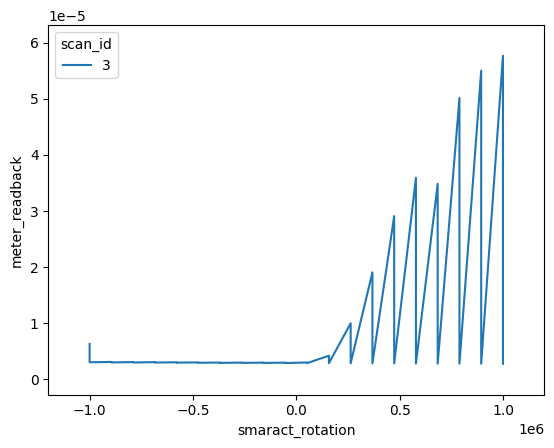

CA.Client.Exception...............................................
    Context: "iocsc1ess5x.ews.bessy.de:5064"
    Source File: ../cac.cpp line 1237
    Current Time: Thu Aug 28 2025 07:31:45.948129766
..................................................................


In [9]:
from databroker import Broker
db = Broker.named('temp')
RE.subscribe(db.insert)
scan_data, = RE(scan([meter.readback], smaract.rotation, -1000000, 1000000, 20, per_step=custom_step), LivePlot('meter_readback', 'smaract_rotation'))

In [87]:
header = db[scan_data]
wavelength = 650e-9

data = header.table()
time = data.time
rbk = data.meter_readback
rot = data.smaract_rotation

In [102]:
import matplotlib.pyplot as plot
rbk_on = []
rbk_off = []
for ele, idx in enumerate(rbk):
    if ele % 2 == 0:
        rbk_on.append(idx)
    else:
        rbk_off.append(idx)

rot_processed = []
for ele, idx in enumerate(rot):
    if ele % 2 == 0:
        rot_processed.append(idx/1e6)

rbk_no_noise = [(rbk_on[i] - rbk_off[i]) for i in range(len(rbk_on))]

In [103]:
import pandas as pd
df = pd.DataFrame()
df['time'] = time
df['readback'] = rbk
df['angle'] = rot

df.to_csv('run_7.csv', index=False)


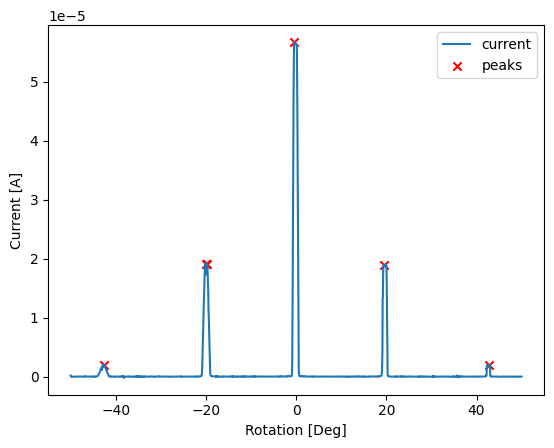

In [106]:
from scipy.signal import find_peaks

peaks, _ = find_peaks(rbk_no_noise, prominence=1e-6)
plot.plot(rot_processed, rbk_no_noise, label = 'current')

pk_vals = [rbk_no_noise[idx] for idx in peaks]
rot_vals = [rot_processed[idx] for idx in peaks]

plot.scatter(rot_vals, pk_vals, marker='x', color='red', label='peaks') 
plot.xlabel("Rotation [Deg]")
plot.ylabel("Current [A]")
plot.legend()

plot.savefig('run_7.png', format='png')

In [107]:
thetas = list(rot[peaks])
center = peaks[2]
center_theta = rot[center]
dtheta = []

for i in [0,1,3,4]:
    dtheta.append(abs((thetas[i] - center_theta) / 1e6))

m = [2,1,1,2]
grating_density = abs(1/(wavelength*(m/np.sin(dtheta))))


[689211.13576151 230046.28851918 425237.99959122 530075.64726611]


In [108]:
np.savetxt('grating_7.csv', grating_density)